# Basic characterizations of UA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 2 # for UA Q3
res_index = 2 # for UA Q3
flux_index = 2 # for UA Q3
TLS_index = 0 # for TLS of interest

2024-04-26 13:52:10,434 - qm - INFO     - Starting session: 5d9f892b-9c0f-4d09-aa44-b98d9055ef7c


In [39]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [4]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [60]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [61]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-26 13:45:48,127 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 13:45:48,137 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-26 13:45:56,107 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (5.984 GHz, -50.000 MHz)
2024-04-26 13:46:10,652 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: 0.000000 V
DC offset to add to Q: -0.000087 V
TOF to add: 8.0 ns


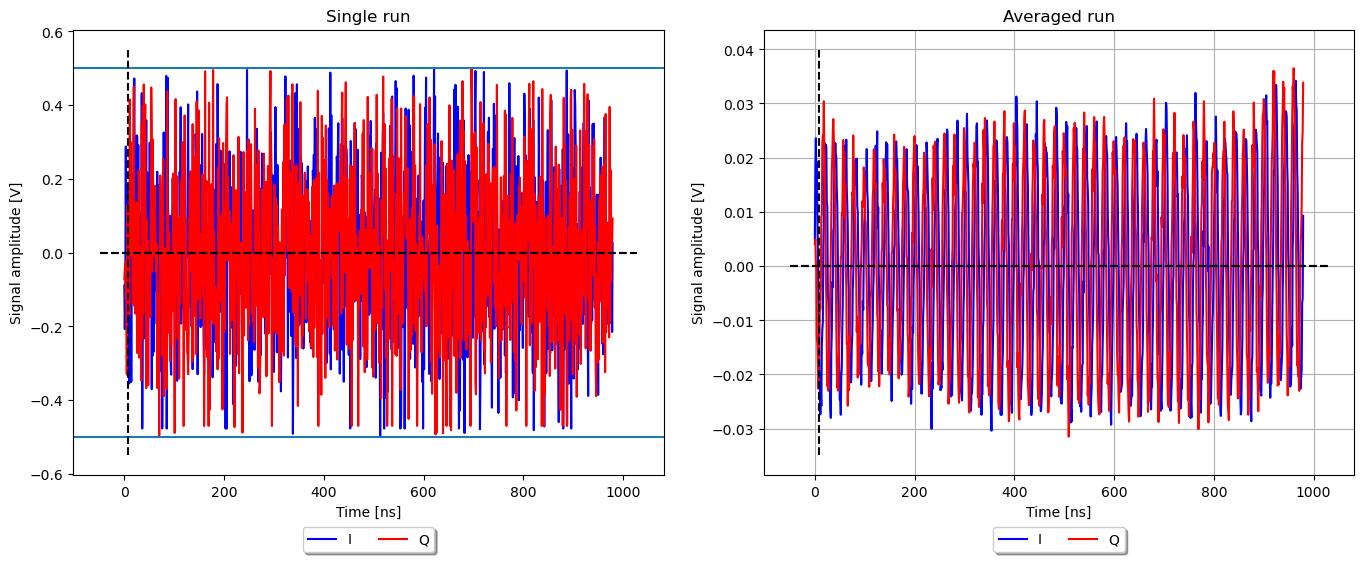

In [70]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [71]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
# machine.global_parameters.time_of_flight = 308
# machine.resonators[res_index].readout_pulse_amp = 0.3
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [72]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.39s


resonator frequency: 7002.312 MHz
Execution stopped by user!


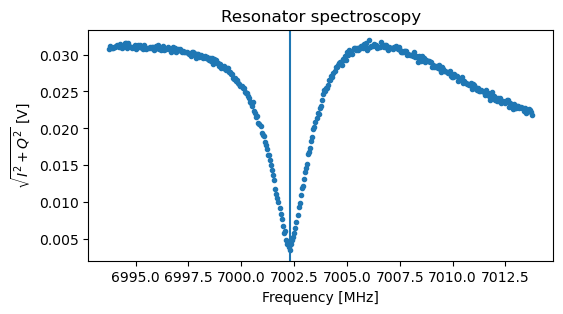

In [73]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [74]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-6e6, 4e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                plot_flag = False, n_avg = 1E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


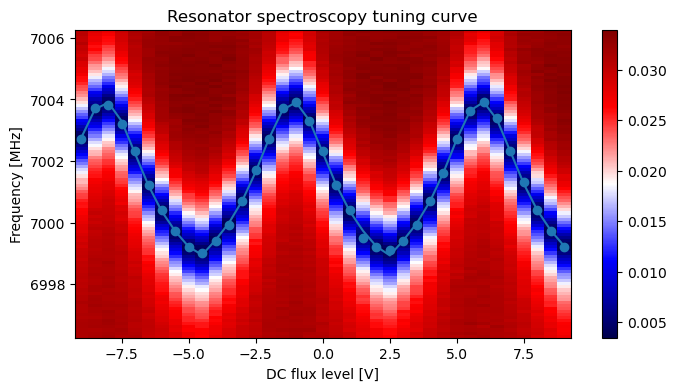

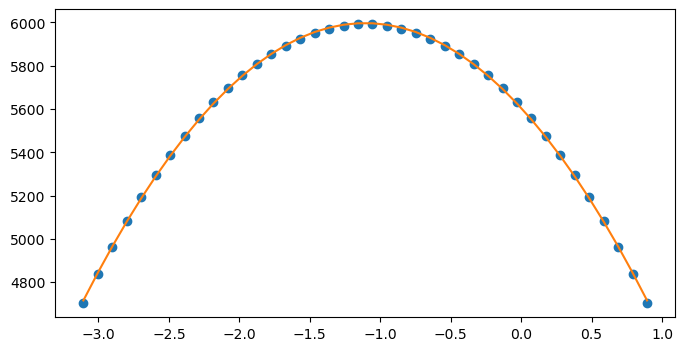

In [75]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [76]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [77]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [5]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.34s
resonator frequency: 7003.928 MHz


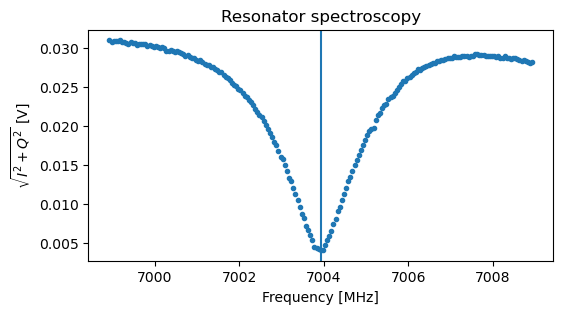

In [79]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 20E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [6]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-04-26 13:52:25,633 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-04-26 13:52:25,636 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 13:52:25,654 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-26 13:52:34,106 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (5.984 GHz, -50.000 MHz)
2024-04-26 13:52:48,370 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [14]:
if False: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-20E6, 20E6 + 1, 0.5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 5E3, cd_time = 30E3, plot_flag = True, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 12.60s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 12.66s


resonant frequency: 6058.880 MHz


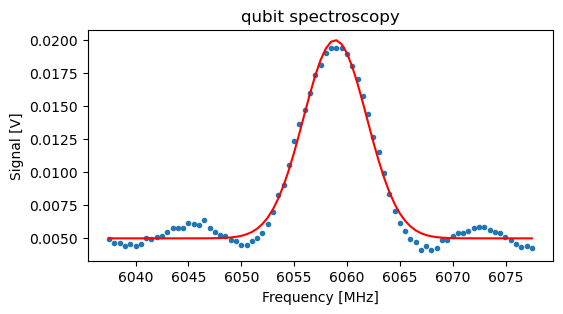

In [16]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine = Analysis.set_machine(machine)

In [17]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-04-26 13:57:45,942 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 13:57:45,951 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-26 13:57:53,846 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (6.109 GHz, -50.000 MHz)
2024-04-26 13:58:08,249 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [18]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 5E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 4.87s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 4.93s


rabi_pi_pulse: 101.0 ns
half period: 102.08 ns


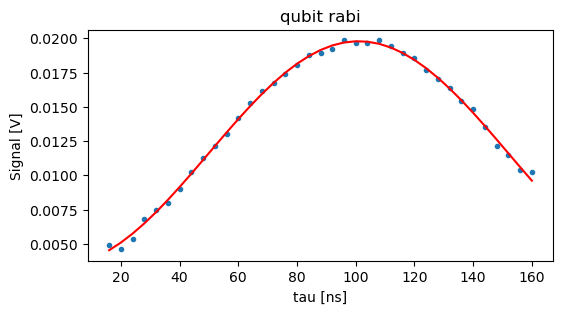

In [19]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [29]:
machine.qubits[qubit_index].pi_length[0] = 100
machine = Analysis.set_machine(machine)

### power rabi

In [47]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 1.5, 0.02) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 5E3, cd_time = 25E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 8.00s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 8.06s


rabi_pi_pulse_amp: 0.02418 V
half period: 0.0233302 V


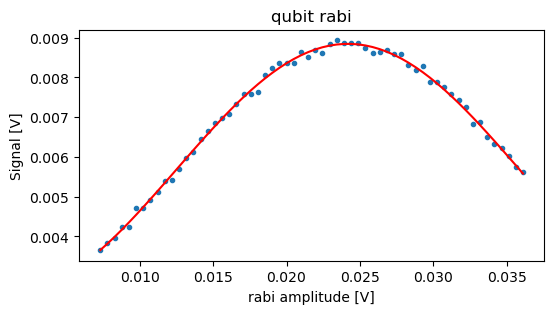

In [48]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [49]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## T1

In [29]:
%matplotlib qt
tau_sweep_abs = np.arange(100,40E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 100E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 60.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 60.43s


Qubit T1 [us]: 2.7459039573053725


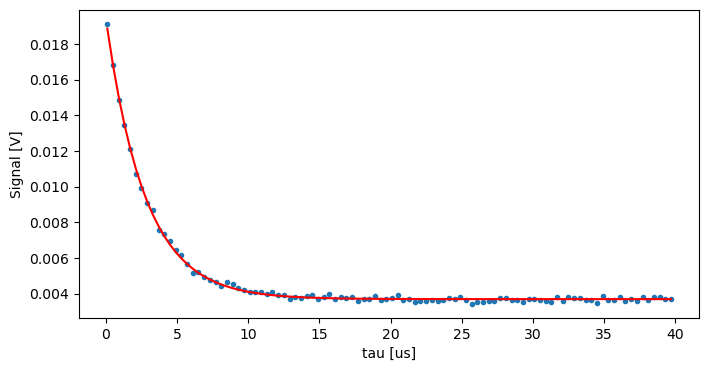

In [30]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [64]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 2500 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 10E3, detuning = 2E6, cd_time = 20E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 134.78s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 134.91s


Qubit T2* [ns]: 3546.153646365503
Detuning [MHz]: 0.7768145800937308
Exponent n: 1.4361771903746838


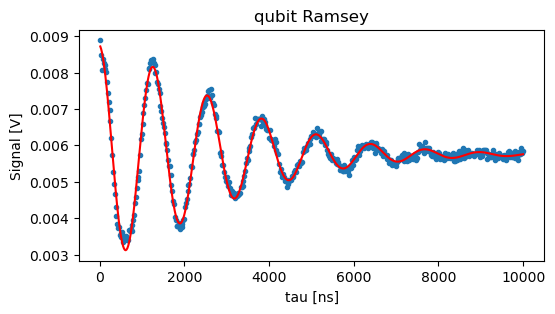

In [66]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-180E6, -100E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 64
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [71]:
machine = Analysis.get_machine()

Progress: [##################################################] 100.0% (n=50/50) --> elapsed time: 1102.12s


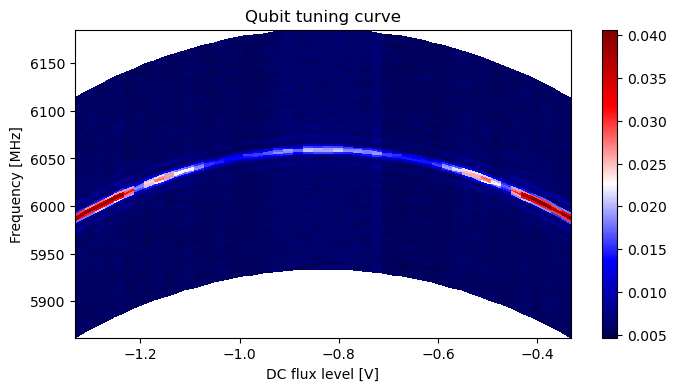

In [72]:
# try the experiment
%matplotlib inline
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.49,0.49+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

In [73]:
# udpate the sweet spot
%matplotlib inline

poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.83192 V


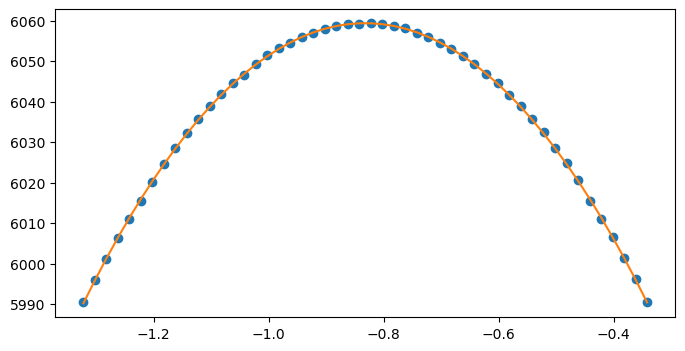

In [74]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [75]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, to find the initial fast flux tuning curve

In [78]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 80E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 4.75, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

2024-04-03 14:12:02,596 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-03 14:12:02,607 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.790 GHz, 270.000 MHz)
2024-04-03 14:12:08,786 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-04-03 14:12:45,953 - qm - INFO     - Performing health check.1% (n=4/7) --> elapsed time: 43.35s


INFO:qm.api.frontend_api:Performing health check


2024-04-03 14:12:45,959 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.642 GHz, 270.000 MHz)
2024-04-03 14:12:52,706 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-04-03 14:13:23,715 - qm - INFO     - Performing health check.7% (n=6/7) --> elapsed time: 81.08s


INFO:qm.api.frontend_api:Performing health check


2024-04-03 14:13:23,722 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.360 GHz, 270.000 MHz)
2024-04-03 14:13:29,533 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 112.94s
2024-04-03 14:13:55,576 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-03 14:13:55,585 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.151 GHz, 270.000 MHz)
2024-04-03 14:14:01,566 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


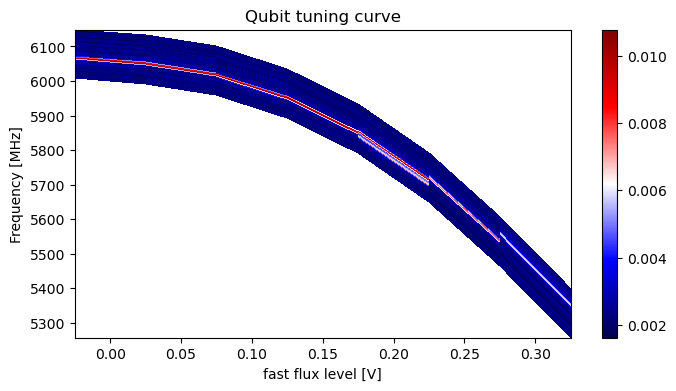

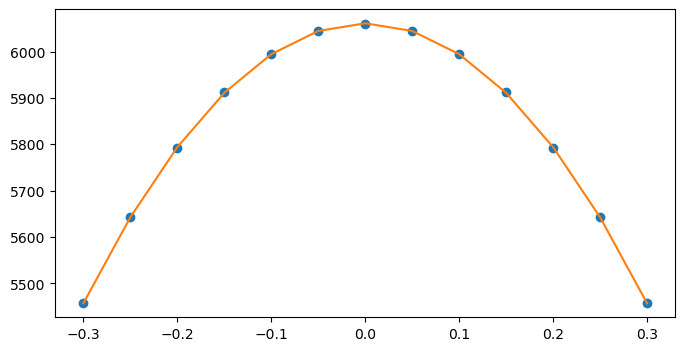

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [79]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [23]:
machine = Analysis.get_machine()

In [24]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -5E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 20E3, plot_flag = True)


-------------------------------------some fast flux > 0.5V, removed from experiment run
2024-04-26 14:14:19,070 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 14:14:19,079 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.764 GHz, 200.000 MHz)
2024-04-26 14:14:25,029 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.29s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.45s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.44s
2024-04-26 14:49:31,104 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 14:49:31,120 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.564 GHz, 200.000 MHz)
2024-04-26 14:49:36,556 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.25s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.42s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.17s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.34s
2024-04-26 15:24:43,073 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 15:24:43,088 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (4.964 GHz, 200.000 MHz)
2024-04-26 15:24:49,202 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.17s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.34s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.11s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.28s
2024-04-26 15:59:55,430 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 15:59:55,444 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (4.764 GHz, 200.000 MHz)
2024-04-26 16:00:01,501 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.44s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.17s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1039.34s
2024-04-26 16:35:08,197 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 16:35:08,208 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (4.164 GHz, 200.000 MHz)
2024-04-26 16:35:13,976 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 987.12s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 987.29s
2024-04-26 16:52:06,282 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 16:52:06,294 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (3.964 GHz, 200.000 MHz)
2024-04-26 16:52:12,401 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


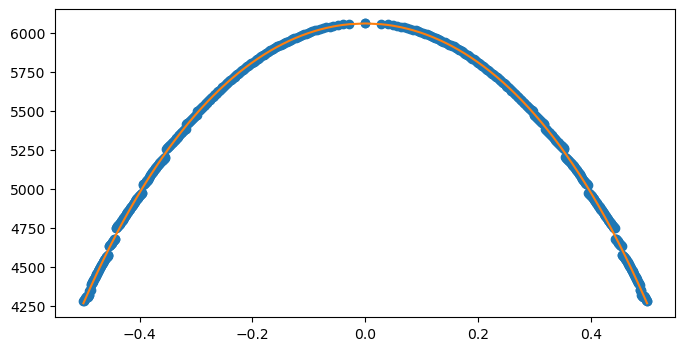

In [25]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

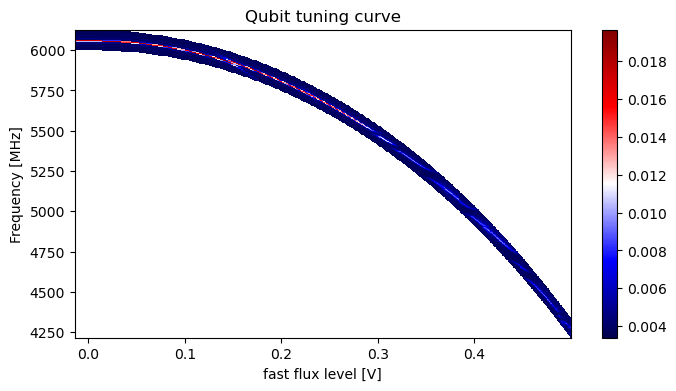

In [26]:
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(ff_sweep_abs, qubit_freq_sweep.T / u.MHz, sig_amp_qubit.T, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [52]:
machine.qubits[qubit_index].f_01 = round(np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0).tolist()*1E6) + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 100E6
machine = Analysis.set_machine(machine)

In [53]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-04-29 14:49:06,559 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-29 14:49:06,568 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-04-29 14:49:14,337 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (6.159 GHz, -100.000 MHz)
2024-04-29 14:49:27,516 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1986.66s


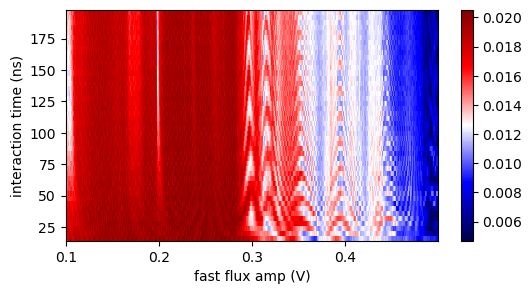

In [31]:
%matplotlib inline
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.1,0.5,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

In [37]:
%matplotlib qt
plt.pcolor(ff_sweep_abs, tau_sweep_abs, sig_amp, cmap='seismic')


### fine, with baking

In [54]:
%matplotlib qt
tau_sweep_abs = np.arange(4,100,1)
ff_sweep_abs = np.arange(0.43,0.46,0.0005)
machine, ff_sweep_abs, tau_swep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1205.86s
Execution stopped by user!


In [67]:
TLS_index = 5

In [68]:
machine.flux_lines[flux_index].iswap.length.append(16)
machine.flux_lines[flux_index].iswap.level.append(0.4485)
# machine.flux_lines[flux_index].iswap.length[TLS_index] = 31
# machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.28
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [69]:
machine = Analysis.get_machine()

In [70]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
# for f_tmp in freq_tls:
#     machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine.qubits[qubit_index].f_tls.append(np.floor(freq_tls[-1]*1E6))    
machine = Analysis.set_machine(machine)

## TLS T1

In [44]:
TLS_index = 1

In [9]:
%matplotlib qt
tau_sweep_abs = np.arange(200,2000E3+1,10E4)

machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 3000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!######################             ] 74.2% (n=3711/5000.0) --> elapsed time: 296.15s


Qubit T1 [us]: 421.75957989251174


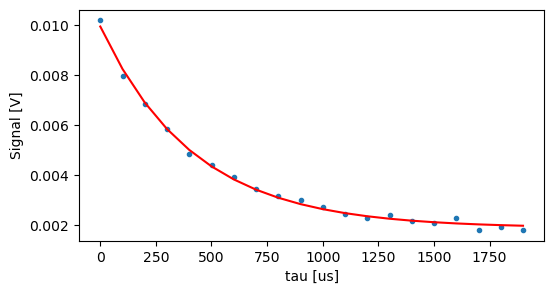

In [11]:
%matplotlib inline
tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [128]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01

In [129]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

AttributeError: 'float' object has no attribute 'append'

In [181]:
TLS_index = 0

In [186]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [187]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-05 09:54:13,681 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 09:54:13,690 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-02-05 09:54:20,944 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (5.483 GHz, 200.000 MHz)
2024-02-05 09:54:33,980 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [188]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-100E6,100E6+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 809.99s


In [12]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

NameError: name 'TLS_freq_sweep' is not defined

### TLS rabi

In [ ]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.219
machine = Analysis.set_machine(machine)

In [141]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 195.88s


T2rabi: 1414.7 ns
rabi_pi_pulse: 32.9 ns
half period: 26.16 ns


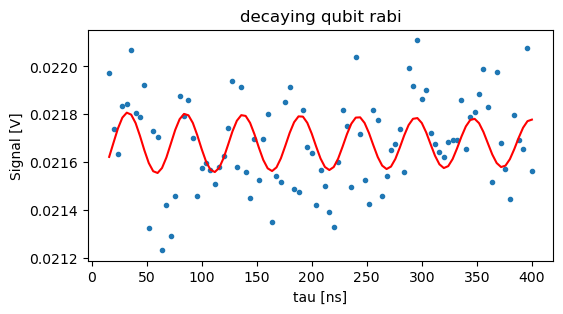

In [143]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [ ]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(100)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = 100
    
machine = Analysis.set_machine(machine)

### Power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 50E3, plot_flag = False, machine = machine)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)